# Weather data comparison

Multi-city exploration of hourly forecasts loaded into DuckDB.

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to your DuckDB warehouse
conn = duckdb.connect("../data/warehouse/weather.duckdb")
print("Successfully connected")

Successfully connected


In [10]:
# Load hourly weather data for all configured cities
weather_query = '''
    SELECT *
    FROM weather_hourly
    ORDER BY city, timestamp
'''

df = conn.execute(weather_query).df()

available_cities = sorted(df["city"].unique())
# print(f"Loaded {len(df)} rows for cities: {', '.join(available_cities)}")
df.tail()

,timestamp,temperature_2m,relativehumidity_2m,precipitation,latitude,longitude,load_date,city
163,2025-12-09 19:00:00,20.1,73.0,0.0,-26.2041,28.0473,2025-12-03,Johannesburg
164,2025-12-09 20:00:00,19.3,77.0,0.0,-26.2041,28.0473,2025-12-03,Johannesburg
165,2025-12-09 21:00:00,18.5,80.0,0.0,-26.2041,28.0473,2025-12-03,Johannesburg
166,2025-12-09 22:00:00,17.8,81.0,0.0,-26.2041,28.0473,2025-12-03,Johannesburg
167,2025-12-09 23:00:00,17.3,82.0,0.0,-26.2041,28.0473,2025-12-03,Johannesburg


In [3]:
# Basic summary stats per city
summary = (
    df.groupby("city")[["temperature_2m", "relativehumidity_2m", "precipitation"]]
    .agg(["mean", "min", "max"])
    .round(2)
)
summary

temperature_2m             relativehumidity_2m              \
                       mean   min   max                mean   min   max   
city                                                                      
Johannesburg          19.37  10.7  26.8               66.51  34.0  98.0   

             precipitation            
                      mean  min  max  
city                                  
Johannesburg          0.11  0.0  3.1

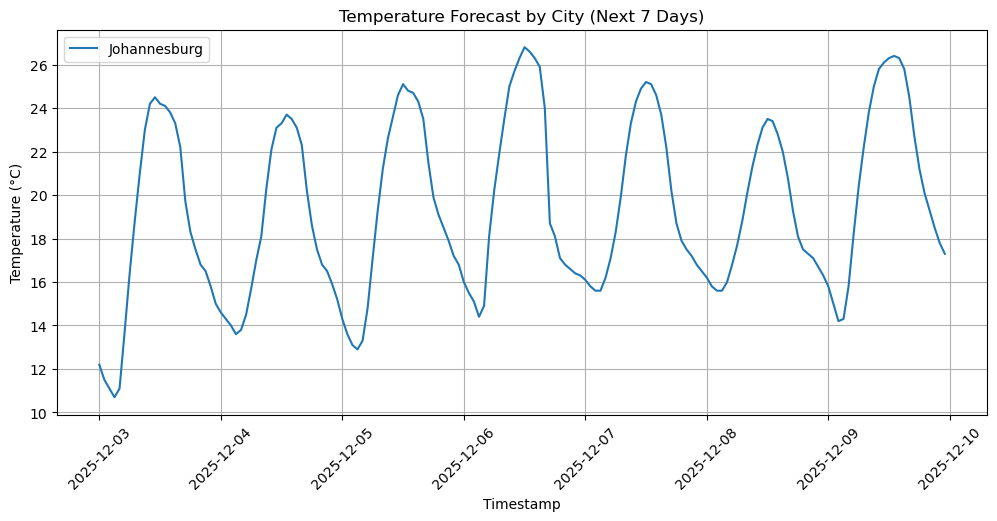

In [4]:
# Temperature comparison across cities
plt.figure(figsize=(12, 5))
for city, city_df in df.groupby("city"):
    plt.plot(city_df["timestamp"], city_df["temperature_2m"], label=city)
plt.title("Temperature Forecast by City (Next 7 Days)")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

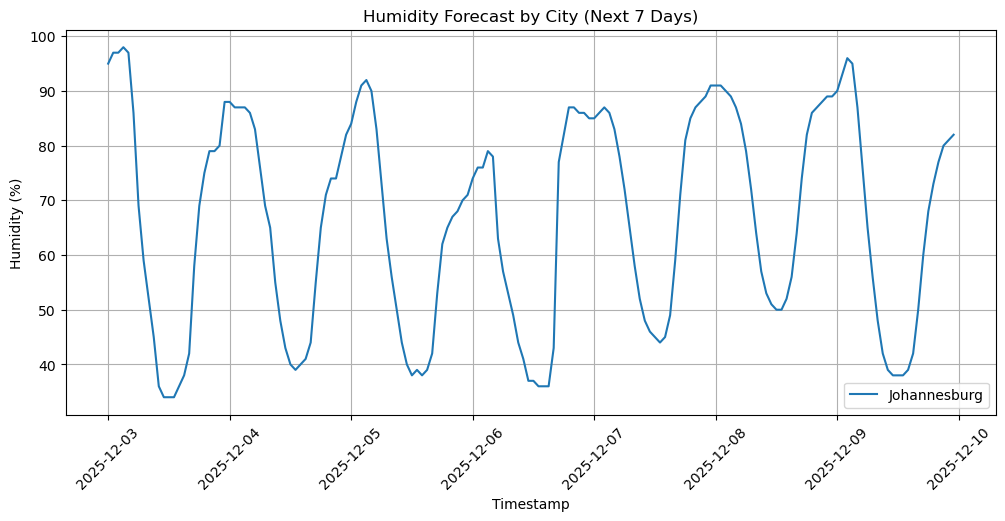

In [5]:
# Humidity comparison across cities
plt.figure(figsize=(12, 5))
for city, city_df in df.groupby("city"):
    plt.plot(city_df["timestamp"], city_df["relativehumidity_2m"], label=city)
plt.title("Humidity Forecast by City (Next 7 Days)")
plt.xlabel("Timestamp")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

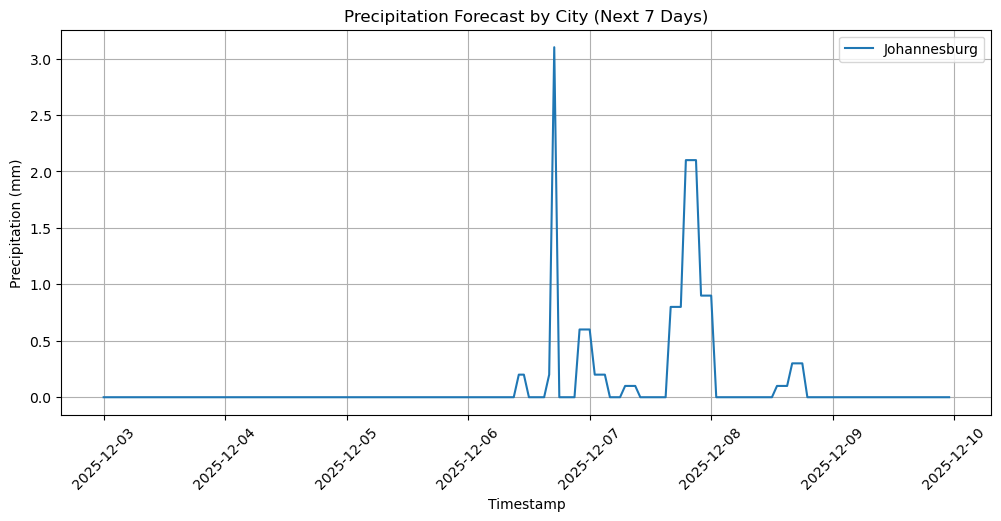

In [6]:
# Precipitation comparison across cities
plt.figure(figsize=(12, 5))
for city, city_df in df.groupby("city"):
    plt.plot(city_df["timestamp"], city_df["precipitation"], label=city)
plt.title("Precipitation Forecast by City (Next 7 Days)")
plt.xlabel("Timestamp")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Daily summary metrics per city
daily_summary_query = '''
    SELECT
        city,
        date_trunc('day', timestamp) AS day,
        AVG(temperature_2m) AS avg_temp,
        MAX(temperature_2m) AS max_temp,
        MIN(temperature_2m) AS min_temp,
        SUM(precipitation) AS total_precipitation
    FROM weather_hourly
    GROUP BY 1, 2
    ORDER BY 2, 1
'''

daily_summary = conn.execute(daily_summary_query).df()
daily_summary.head()

,city,day,avg_temp,max_temp,min_temp,total_precipitation
0,Johannesburg,2025-12-03,18.141667,24.5,10.7,0.0
1,Johannesburg,2025-12-04,18.237500,23.7,13.6,0.0
2,Johannesburg,2025-12-05,19.320833,25.1,12.9,0.0
3,Johannesburg,2025-12-06,20.258333,26.8,14.4,4.9
4,Johannesburg,2025-12-07,19.770833,25.2,15.6,12.0


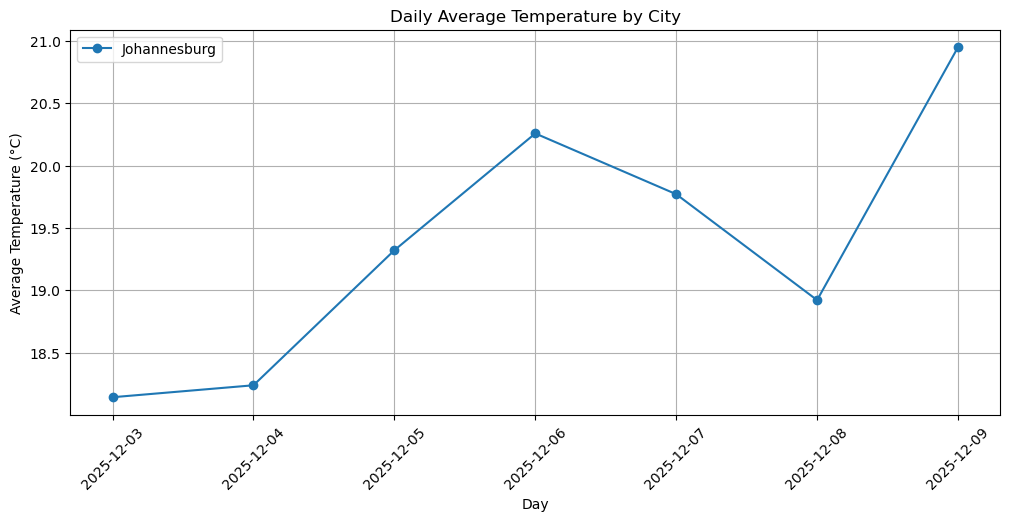

In [8]:
# Plot daily average temperature comparison
plt.figure(figsize=(12, 5))
for city, city_df in daily_summary.groupby("city"):
    plt.plot(city_df["day"], city_df["avg_temp"], marker='o', label=city)
plt.title("Daily Average Temperature by City")
plt.xlabel("Day")
plt.ylabel("Average Temperature (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Temperature spread between the first two cities (if available)
pivot_avg = daily_summary.pivot(index="day", columns="city", values="avg_temp")
if pivot_avg.shape[1] >= 2:
    base, compare = pivot_avg.columns[:2]
    diff = pivot_avg[compare] - pivot_avg[base]
    print(f"Average temperature difference ({compare} - {base})")
    diff.to_frame(name="temp_diff").dropna()
else:
    print("Need at least two cities to compare.")

Need at least two cities to compare.
